# Clustering the coworking spaces.

## Merge the description from the JSON file of each city.

In [1]:
import pandas as pd
import json

# JSON file paths and their corresponding cities
json_files = [
    ("/workspaces/Coworking/src/results/Madrid/Madrid_coworking_spaces.json", "Madrid"),
    ("/workspaces/Coworking/src/results/Barcelona/Barcelona_coworking_spaces.json", "Barcelona"),
    ("/workspaces/Coworking/src/results/New York/New_York_coworking_spaces.json", "New York"),
    ("/workspaces/Coworking/src/results/Tokyo/tokyo_coworking_spaces.json", "Tokyo"),
    ("/workspaces/Coworking/src/results/Sao Paulo/sp_coworking_spaces.json", "Sao Paulo")
]

# List to hold all dataframes
dfs = []

# Load each JSON file, convert to DataFrame, and add 'city'
for file_path, city in json_files:
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        df = pd.DataFrame(data)
        df['city'] = city  # Add city column
        dfs.append(df)

# Concatenate all the dataframes into one
merged_df = pd.concat(dfs, ignore_index=True)

# Save merged data
merged_df.to_csv("merged_coworking_spaces.csv", index=False)
merged_df.to_json("merged_coworking_spaces.json", orient="records", lines=True, force_ascii=False)

print("All JSON files have been merged successfully with city column included!")


All JSON files have been merged successfully with city column included!


## Extract amenities from description.

In [2]:
# Strip whitespace from string columns
string_cols = ['url', 'name', 'address', 'description', 'price']
merged_df[string_cols] = merged_df[string_cols].apply(lambda x: x.str.strip())

# Convert empty strings to NaN
merged_df.replace({'': pd.NA, '[]': pd.NA}, inplace=True)

# Handle amenities (convert string "[]" to empty list)
merged_df['amenities'] = merged_df['amenities'].apply(
    lambda x: [] if x == '[]' or x is pd.NA else eval(x) if isinstance(x, str) else x
)

In [3]:
# Split address into components if needed
merged_df[['street', 'city', 'country']] = (
    merged_df['address'].str.extract(r'^(.*?),\s*(.*?),\s*(.*)$')
)

In [4]:
# Split address into components if needed
merged_df[['street', 'city', 'country']] = (
    merged_df['address'].str.extract(r'^(.*?),\s*(.*?),\s*(.*)$')
)

In [5]:
import pandas as pd
import re

# Sample list of common coworking amenities (expand as needed)
AMENITIES_KEYWORDS = {
    "wifi": ["wi-fi", "wifi", "internet"],
    "coffee": ["coffee", "espresso", "café"],
    "meeting_rooms": ["meeting room", "conference room"],
    "printing": ["printer", "printing"],
    "parking": ["parking", "garage"],
    "kitchen": ["kitchen", "pantry"],
    "phone_booth": ["phone booth", "call booth"],
    "lounge": ["lounge", "breakout area"],
    "locker": ["locker", "storage"],
    "shower": ["shower"],
    "gym": ["gym", "fitness"],
    "events": ["events", "workshops"],
    "pet_friendly": ["pet friendly", "dogs allowed"],
    "bike_storage": ["bike storage", "bicycle parking"],
    "rooftop": ["rooftop", "terrace"],
    "24/7_access": ["24/7", "24 hour access"],
}

def extract_amenities(description):
    if pd.isna(description):
        return []
    
    amenities_found = set()
    description_lower = description.lower()
    
    for amenity, keywords in AMENITIES_KEYWORDS.items():
        for keyword in keywords:
            if re.search(rf"\b{re.escape(keyword)}\b", description_lower):
                amenities_found.add(amenity)
                break
    
    return list(amenities_found)

# Apply to DataFrame
merged_df["extracted_amenities"] = merged_df["description"].apply(extract_amenities)

In [6]:
import pandas as pd

merged_df['extracted_amenities'].to_csv('extracted_amenities.csv', index=False)

In [7]:
import pandas as pd

# 1. Ensure 'extracted_amenities' exists and is properly formatted
if 'extracted_amenities' not in merged_df.columns:
    merged_df['extracted_amenities'] = merged_df['description'].apply(extract_amenities)

# 2. Explode the amenities list (skip empty lists)
amenities_expanded = merged_df.explode('extracted_amenities').dropna(subset=['extracted_amenities'])

# 3. Create dummy variables only if there are amenities
if not amenities_expanded.empty:
    amenities_dummies = pd.get_dummies(
        amenities_expanded['extracted_amenities'],
        prefix='has_amenity'
    ).groupby(amenities_expanded.index).max()
    
    # 4. Merge back (fill missing with 0)
    merged_df = merged_df.join(amenities_dummies).fillna(0)
else:
    print("No amenities found in descriptions.")
    # Initialize empty amenity columns if needed
    for amenity in AMENITIES_KEYWORDS.keys():
        merged_df[f'has_amenity_{amenity}'] = 0

/tmp/ipykernel_77070/3022538330.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.join(amenities_dummies).fillna(0)


In [8]:
amenity_counts = amenities_dummies.sum().sort_values(ascending=False)
print("Most common amenities:")
print(amenity_counts.head(10))

Most common amenities:
has_amenity_events           394
has_amenity_wifi             288
has_amenity_coffee           241
has_amenity_meeting_rooms    146
has_amenity_kitchen          142
has_amenity_parking          120
has_amenity_24/7_access      117
has_amenity_printing         116
has_amenity_lounge           113
has_amenity_rooftop           80
dtype: int64


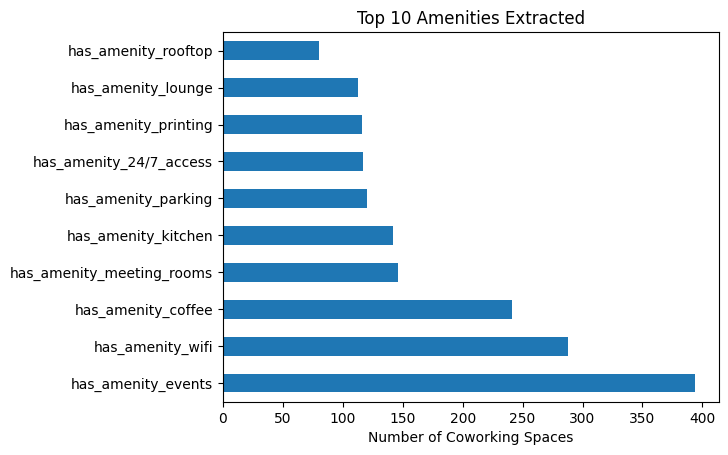

In [9]:
import matplotlib.pyplot as plt

amenity_counts.head(10).plot(kind="barh", title="Top 10 Amenities Extracted")
plt.xlabel("Number of Coworking Spaces")
plt.show()

## Divide the spaces in clusters with K-Means

In [10]:
amenity_cols = [col for col in merged_df.columns if col.startswith('has_amenity_')]
X = merged_df[amenity_cols]

# Standardize (though binary data may not need it)
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [11]:
import re

pattern = re.compile(r'\b(?:madrid|barcelona|tokyo|new york|overview|cowork|space|office|shared|city|address|booking)\b', flags=re.IGNORECASE)

merged_df['name_clean'] = merged_df['name'].apply(lambda x: pattern.sub('', str(x)).strip())
merged_df['description_clean'] = merged_df['description'].apply(lambda x: pattern.sub('', str(x)).strip())

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=200)
X_tfidf = tfidf.fit_transform(merged_df['description_clean'].fillna(''))

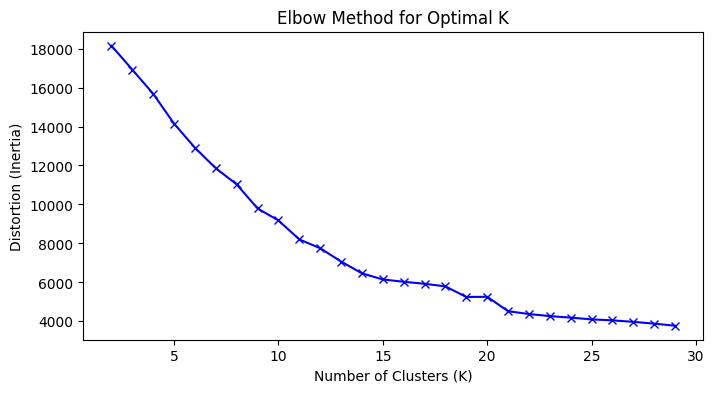

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K_range = range(2, 30)  # Test K=2 to K=10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)  # Sum of squared distances

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [14]:
optimal_k = 21  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(X_scaled)

In [15]:
# Get top keywords per cluster
feature_names = tfidf.get_feature_names_out()
for i in range(21):
    top_keywords = [feature_names[j] for j in kmeans.cluster_centers_[i].argsort()[-5:]]
    print(f"Cluster {i}: {', '.join(top_keywords)}")


Cluster 0: able, bright, best, available, accommodate
Cluster 1: alike, able, bright, best, available
Cluster 2: best, available, access, book, area
Cluster 3: bright, best, area, borough, available
Cluster 4: brooklyn, amenities, architecture, ample, able
Cluster 5: alike, brooklyn, areas, area, bright
Cluster 6: architecture, brooklyn, area, amenities, best
Cluster 7: areas, borough, 24, amenities, alike
Cluster 8: bright, best, available, accommodate, 24
Cluster 9: architecture, amenities, areas, access, borough
Cluster 10: area, available, access, amenities, architecture
Cluster 11: amenities, book, brooklyn, access, areas
Cluster 12: access, area, book, brooklyn, ample
Cluster 13: best, available, areas, ample, able
Cluster 14: architecture, accommodate, access, brooklyn, book
Cluster 15: 24, area, brooklyn, access, amenities
Cluster 16: able, bright, best, available, brooklyn
Cluster 17: bright, best, available, brooklyn, access
Cluster 18: borough, area, brooklyn, amenities, boo

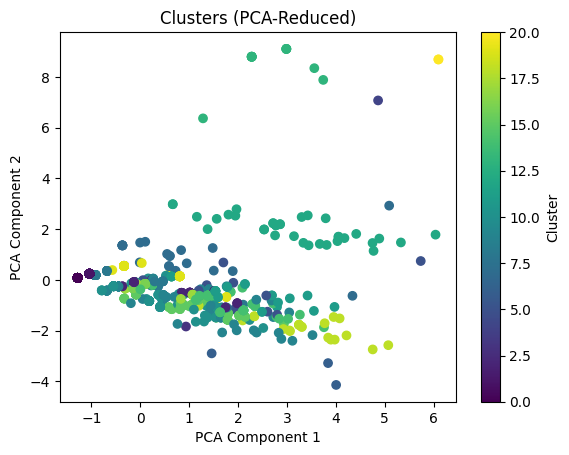

In [16]:
from sklearn.decomposition import PCA

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_df['cluster'], cmap='viridis')
plt.title('Clusters (PCA-Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()